# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# prerequisites
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras import backend as K
from keras import objectives
from tensorflow.keras.utils import to_categorical
from scipy.stats import norm

# Dataset visulaization

11493376/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


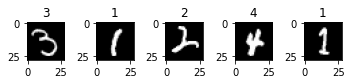

In [2]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

# Preprocess

In [3]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# Encoding Layer

In [4]:
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(input_data)       # (64, (5,5), activation='relu')

encoder = tensorflow.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder)     ##(64, (3,3), activation='relu')

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

# Sampling in Latent Space

In [5]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random


In [6]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [7]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Decoding Layer

In [8]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = layers.Dense(7 * 7 * 64, activation="relu")(decoder_input)
decoder = tensorflow.keras.layers.Reshape((7, 7, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)

In [9]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [10]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

# Build the Vae Model

In [11]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [12]:

def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

In [13]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 69076     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='model{epoch:01d}.ckpt', save_freq=938, verbose = 1, save_best_only = False, save_weights_only=True)

In [15]:
history=autoencoder.fit(train_data, train_data, epochs=10, batch_size=64, validation_data=(test_data, test_data),callbacks = [checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59648/60000 [============================>.] - ETA: 0s - loss: 47.4125
Epoch 00001: saving model to model1.ckpt
60000/60000 [==============================] - 44s 734us/sample - loss: 47.3768 - val_loss: 40.1777
Epoch 2/10
59584/60000 [============================>.] - ETA: 0s - loss: 39.1654
Epoch 00002: saving model to model2.ckpt
60000/60000 [==============================] - 6s 107us/sample - loss: 39.1472 - val_loss: 38.4185
Epoch 3/10
59840/60000 [============================>.] - ETA: 0s - loss: 37.8860
Epoch 00003: saving model to model3.ckpt
60000/60000 [==============================] - 6s 108us/sample - loss: 37.8856 - val_loss: 37.5607
Epoch 4/10
59776/60000 [============================>.] - ETA: 0s - loss: 37.1710
Epoch 00004: saving model to model4.ckpt
60000/60000 [==============================] - 6s 108us/sample - loss: 37.1697 - val_loss: 37.0987
Epoch 5/10
59584/60000 [============================>.] - ETA

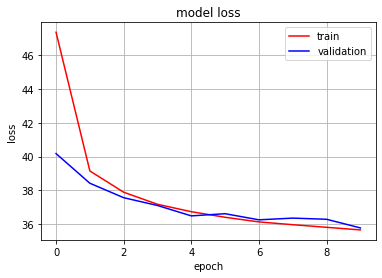

In [16]:
### Plot the Loss Curves
fig = plt.figure()
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

In [18]:
# model = tensorflow.keras.models.load_model('model03.h5', custom_objects={'get_loss': get_loss})
# model.summary()

model1 = tensorflow.keras.models.Model(input_data, decoded)
model1.load_weights('model1.ckpt')
model2 = tensorflow.keras.models.Model(input_data, decoded)
model2.load_weights('model10.ckpt')

# Oroginal Data & Reconstructed Images

Real Test Images


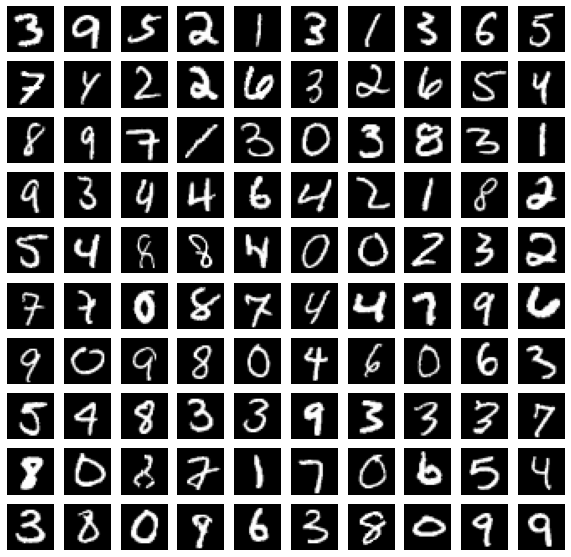

Reconstructed Images with Variational Autoencoder


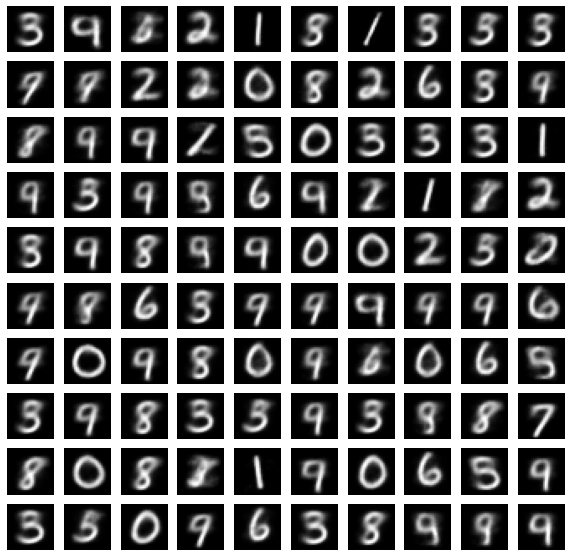

Reconstructed Images with Variational Autoencoder


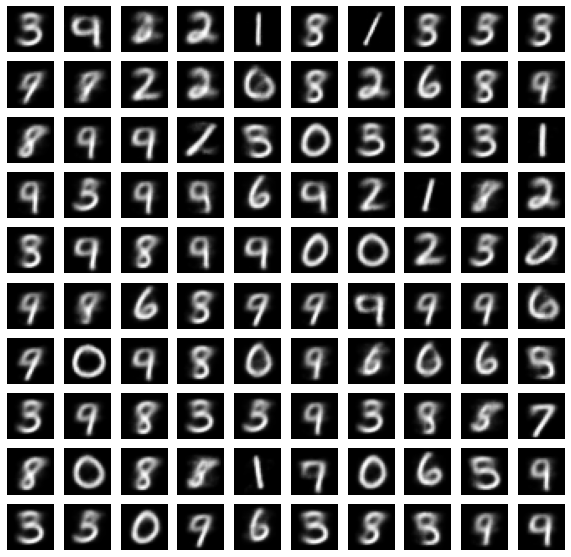

In [19]:
offset=500
print ("Real Test Images")
fig1 = plt.figure(figsize=(10,10))
# Real Images
for i in range(10):
  for j in range(10):
    plt.subplot(10,10,i+j*10+1, frameon=False)
    plt.imshow(test_data[i+j*10+offset,:,:, -1], cmap='gray')
    plt.axis('off')
plt.show()


##1
# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
fig1 = plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10,10,i+j*10+1, frameon=False)
    output = model1.predict(np.array([test_data[i+j*10+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.axis('off')
plt.show()

##2
# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
fig1 = plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    plt.subplot(10,10,i+j*10+1, frameon=False)
    output = model2.predict(np.array([test_data[i+j*10+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.axis('off')
plt.show()

# Latent Space visualization & samples

In [20]:

x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

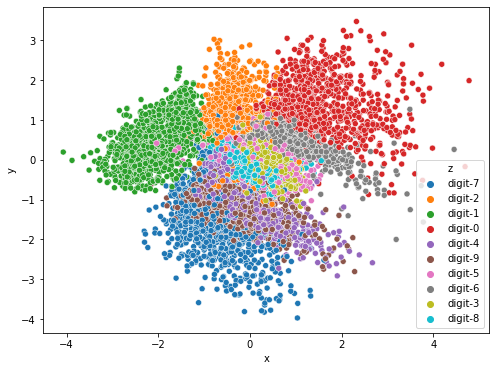

In [21]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

In [22]:
generator_model = decoder_model

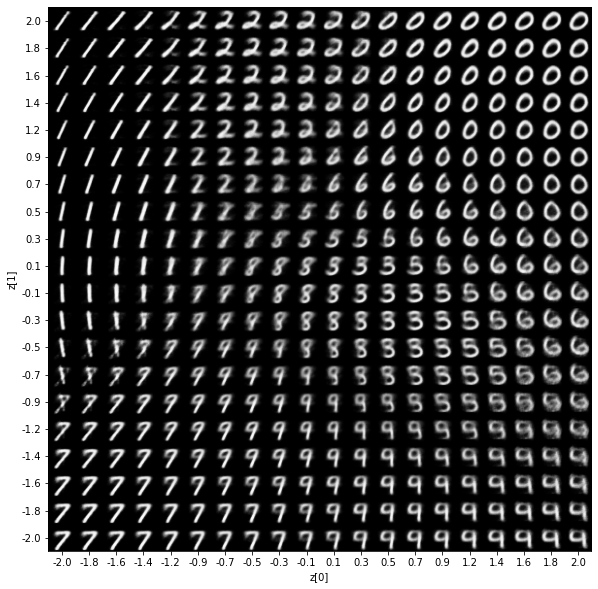

In [23]:
def plot_latent_space(vae, n=20, figsize=10):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(generator_model)